# Find Wildfire Detection Zones 

## Problem
Wildfires spread a great deal before firefighters reach them. Design a system that detects such fires and notifies the fire station.

## Implementation
Wildfires release many chemical compounds into the atmosphere. The presence of these compounds can attenuate and phase shift RF signals, thus wildfires can be detected using RF signals with context from other factors e.g. the weather. These RF signals may be sent and recieved by transcievers along the perimeter of an area of interest. The coverage of this area is dependant on the distribution of the transceivers.

This program determines points within an area of interest that the transceivers can detect fires at at a quadratic time complexity and linear space complexity. This program may also be used to find the ideal distribution of transceivers on a contour by brute force.

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Wildfire System Attributes

These attributes are initialized as objects to organize their characteristics:

#### Node (RF trancievers)
- X and y coordinates

#### Path (Path between two trancievers along a contour)
- Start and end nodes

- Slope and y intercept in cartesian coordinates

- Length


In [333]:
#Node class stores the attributes of the fire tower
#The location of the tower in cartesian coordinates are the relevant attributes 
class Node:
    def __init__(self, x_coord, y_coord):
        self.x_coord = x_coord
        self.y_coord = y_coord

#The path class stores the attributes of a path between two arbitrary nodes
#The slope of the path M and the y intercept B are the relevant attributes
class Path:
    def __init__(self, node1, node2):
        self.node1 = node1
        self.node2 = node2

        #Finding the slope of line connecting the two nodes
        dy = self.node2.y_coord - self.node1.y_coord
        dx = self.node2.x_coord - self.node1.x_coord

        #finding the path length
        self.length = (dy**2 + dx**2)**0.5

        #Edge case: infinite slope
        if dx == 0:
            if dy >= 0:
                self.slope = float("inf")
            else:
                self.slope = float("-inf")
        #Normal case
        else:
            self.slope = dy/dx
        
        #Finding the y_intercept of the line connecting the two nodes
        #Edge case: infinite slope
        if self.slope == float("inf") or self.slope == float("-inf"):
            self.y_int = None
        #Normal case
        else:
            self.y_int = node1.y_coord - self.slope*node1.x_coord

## Path Property Checks

A valid path between two nodes has one property:
- A path between two nodes must be intersected by at least one other path (this allows for fires to be located)

- A point of intersection may not be at a Node "trivial solution"

## Checking if Paths are Intersected 
Two straight line paths intersect when they are equivalent: $$Ax + B = Cx + D$$ If their slopes are equivalent: $$A = C$$ then they are parallel and will never intersect. Otherwise, they will intersect when their x coordinates equal the following: $$ \frac{D-B}{A-C} $$ If both the x and y value of intersection are within the bounds of both lines (not outside the contour) then their intersection is valid

In [334]:

#Check if two non-parallel paths intersect within the contour
def pathsIntersect(path1, path2):

    #Coordinates of point of intersection
    x_intersect = 0
    y_intersect = 0

    #Edge case: both paths have infinite slope
    if (path1.slope == float("inf") or path1.slope == float("-inf")) and (path2.slope == float("inf") or path2.slope == float("-inf")):
        return False, x_intersect, y_intersect
    
    #Edge case: both paths have the same slope
    elif (path1.slope == path2.slope):
        return False, x_intersect, y_intersect
    
    #Edge case: one path has infinite slope
    elif (path1.slope == float("inf") or path1.slope == float("-inf")):
        x_intersect = path1.node1.x_coord
        y_intersect = path2.slope*x_intersect + path2.y_int
    
    elif (path2.slope == float("inf") or path2.slope == float("-inf")):
        x_intersect = path2.node1.x_coord
        y_intersect = path1.slope*x_intersect + path1.y_int
    
    #Find the x and y values of the point of intersection
    else:
        x_intersect = (path2.y_int - path1.y_int)/(path1.slope - path2.slope)
        y_intersect = path1.slope*x_intersect + path1.y_int

    #Determine if the points of intersection are within bounds
    d1FromPath1 = ((path1.node1.x_coord - x_intersect)**2 + (path1.node1.y_coord - y_intersect)**2)**0.5
    d2FromPath1 = ((path1.node2.x_coord - x_intersect)**2 + (path1.node2.y_coord - y_intersect)**2)**0.5
    d1FromPath2 = ((path2.node1.x_coord - x_intersect)**2 + (path2.node1.y_coord - y_intersect)**2)**0.5
    d2FromPath2 = ((path2.node2.x_coord - x_intersect)**2 + (path2.node2.y_coord - y_intersect)**2)**0.5

    if (d1FromPath1 <= path1.length and d2FromPath1 <= path1.length):
        if (d1FromPath2 <= path2.length and d2FromPath2 <= path2.length):
            return True, x_intersect, y_intersect
    
    return False, x_intersect, y_intersect

## Processing Data

The conditions above are applied to datasets using the contourForest function

In [335]:
def contourForest(tower_x_coords, tower_y_coords):

    #The contour of the forest defined by x-y coordinates of towers along its perimeter
    contour = np.array([])

    #The towers along the contour of the forest
    nodes = np.array([])

    #Valid paths between nodes
    paths = np.array([])

    #The intersection points between nodes
    x_intersects = np.array([])
    y_intersects = np.array([])

    #Create contour
    contour = np.array([[tower_x_coords[i], tower_y_coords[i]] for i in range(len(tower_x_coords))])

    #Create nodes
    nodes = np.array([Node(tower_x_coords[i], tower_y_coords[i]) for i in range(len(tower_x_coords))])

    #Initialize paths 
    allPaths = np.array([])
    for node1 in nodes:
        for node2 in nodes:
            if node1 == node2:
                continue
            else:
                allPaths = np.append(allPaths, Path(node1, node2))

    #Check if the path intersects another path
    #error value due to floating point error when comparing intersect pt to node location
    error = 0.1
    for path in allPaths:
        atLeastOneIntersect = False
        for otherPath in allPaths:
            if path == otherPath:
                continue
            else:
                isIntersect, x, y = pathsIntersect(path, otherPath)

                #Checking if the point of intersection is at a Node
                for node in nodes: 
                    if (abs(x-node.x_coord) < error) and (abs(y-node.y_coord) < error):
                        isIntersect = False
                        break

                #Saving valid paths and points of intersection
                if isIntersect:
                    atLeastOneIntersect = True
                    x_intersects = np.append(x_intersects, x)
                    y_intersects = np.append(y_intersects, y)

        if atLeastOneIntersect:
            paths = np.append(paths, path)
            
    return nodes, paths, x_intersects, y_intersects

## Wildfire Detection with 8 Nodes

The contourForest function is called for a circular, square, and random distribution of 8 trancievers. Shapes with greater curvature and symetry tend to have a greater number of fire detection points. Curved shapes also have shorter median path lengths, which may be better for fire detection sensitivity.

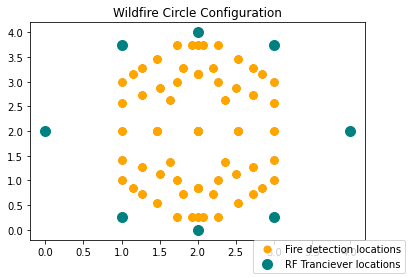

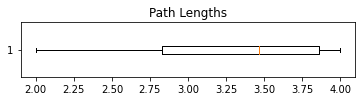

Nodes: 8
Paths: 40
Intersections: 560
Nodes per Intersection: 0.014286
Paths per Intersection: 0.071429
────────────────────────────────────────────────────────────────────────────────────────────────────


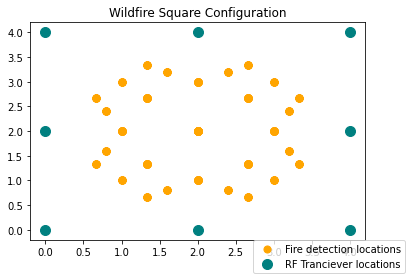

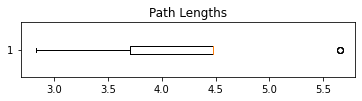

Nodes: 8
Paths: 32
Intersections: 400
Nodes per Intersection: 0.020000
Paths per Intersection: 0.080000
────────────────────────────────────────────────────────────────────────────────────────────────────


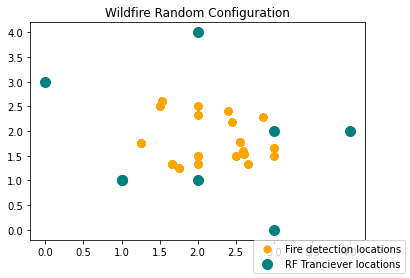

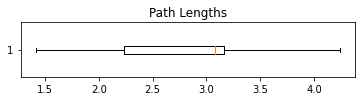

Nodes: 8
Paths: 32
Intersections: 288
Nodes per Intersection: 0.027778
Paths per Intersection: 0.111111
────────────────────────────────────────────────────────────────────────────────────────────────────


In [340]:
csvs = [
    "Circle.csv",
    "Square.csv",
    "Random.csv",
]

for csv in csvs:

    data = pd.read_csv(csv)
    tower_x_coords = data["x_coord"].array
    tower_y_coords = data["y_coord"].array
    nodes, paths, x_intersects, y_intersects = contourForest(tower_x_coords, tower_y_coords)
    pathlengths = [path.length for path in paths]

    fig = plt.figure()
    plt.title("Wildfire {dataset} Configuration".format(dataset = csv.removesuffix(".csv")))
    fires = plt.scatter(x_intersects, y_intersects, color="orange", s=50)
    detectors = plt.scatter(tower_x_coords, tower_y_coords, color="teal", s=100)
    fires.set_label("Fire detection locations")
    detectors.set_label("RF Tranciever locations")
    '''
    for path in paths:
        point1 = [path.node1.x_coord, path.node1.y_coord]
        point2 = [path.node2.x_coord, path.node2.y_coord]
        x = [point1[0], point2[0]]
        y = [point1[1], point2[1]]
        plt.plot(x, y, color = "teal")
    '''
    fig.legend(loc='lower right')
    plt.show()

    plt.figure().set_figheight(1)
    plt.title("Path Lengths")
    plt.boxplot(pathlengths, vert=False)
    plt.show()

    print("Nodes: {numNodes}".format(numNodes = len(nodes)))
    print("Paths: {numPaths}".format(numPaths = len(paths)))
    print("Intersections: {numIntersects}".format(numIntersects = len(x_intersects)))
    print("Nodes per Intersection: {bcost:.6f}".format(bcost = len(nodes)/len(x_intersects)))
    print("Paths per Intersection: {stime:.6f}".format(stime = len(paths)/len(x_intersects)))
    print('─' * 100)

## Wildfire Detection with 32 Nodes

The contourForest function is called for a circular, square, and random distribution of 32 trancievers. 

- Path lengths didn't change significantly

- The number of intersections increased significantly for all shapes compared to when they had 8 nodes. 

- The ratios of nodes and paths to intersections also decreased significantly to similar values for all shapes. 

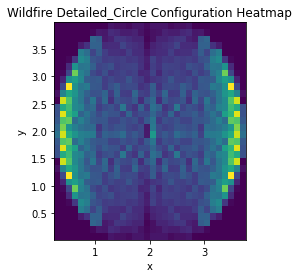

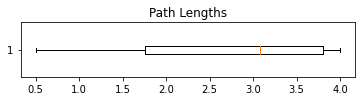

Nodes: 32
Paths: 928
Intersections: 252048
Nodes per Intersection: 0.000127
Paths per Intersection: 0.003682
────────────────────────────────────────────────────────────────────────────────────────────────────


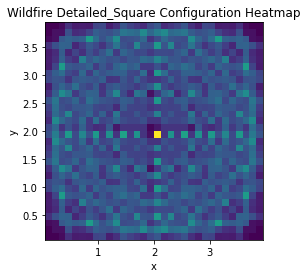

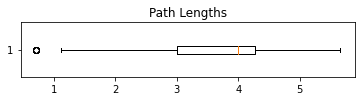

Nodes: 32
Paths: 704
Intersections: 217976
Nodes per Intersection: 0.000147
Paths per Intersection: 0.003230
────────────────────────────────────────────────────────────────────────────────────────────────────


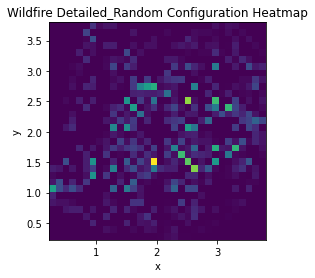

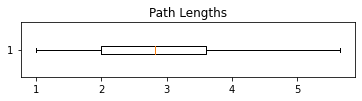

Nodes: 32
Paths: 848
Intersections: 124536
Nodes per Intersection: 0.000257
Paths per Intersection: 0.006809
────────────────────────────────────────────────────────────────────────────────────────────────────


In [337]:
csvs = [
    "Detailed_Circle.csv",
    "Detailed_Square.csv",
    "Detailed_Random.csv"
]

for csv in csvs:
    data = pd.read_csv(csv)
    tower_x_coords = data["x_coord"].array
    tower_y_coords = data["y_coord"].array
    nodes, paths, x_intersects, y_intersects = contourForest(tower_x_coords, tower_y_coords)
    pathlengths = [path.length for path in paths]
 
   # Create heatmap
    heatmap, xedges, yedges = np.histogram2d(x_intersects, y_intersects, bins=(32,32))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Plot heatmap
    plt.figure()
    plt.title("Wildfire {dataset} Configuration Heatmap".format(dataset = csv.removesuffix(".csv")))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.imshow(heatmap, extent=extent)
    plt.show()

    plt.figure().set_figheight(1)
    plt.title("Path Lengths")
    plt.boxplot(pathlengths, vert=False)
    plt.show()

    print("Nodes: {numNodes}".format(numNodes = len(nodes)))
    print("Paths: {numPaths}".format(numPaths = len(paths)))
    print("Intersections: {numIntersects}".format(numIntersects = len(x_intersects)))
    print("Nodes per Intersection: {bcost:.6f}".format(bcost = len(nodes)/len(x_intersects)))
    print("Paths per Intersection: {stime:.6f}".format(stime = len(paths)/len(x_intersects)))
    print('─' * 100)

## Relationship Between Nodes and Intersection Points

When implementing this wildfire detection system, a general relationship between the number of nodes along a contour and the number of fire detection points must be known. This block plots the following relations:

#### Number of nodes vs the inverse number of intersections (I)
- Multiplying the area being monitored by this value yields the average area of the smallest fire that can be detected

#### Number of nodes vs the number of nodes per intersection (NPI)
- The "cost" of each fire detection point in nodes (monetary). 

#### Number of nodes vs the number of paths per intersection (PPI)
- The cost of each fire detection point in paths (time).

All of these values decay at a decreasing exponential rate (non-linear on a logarithmic scale), approaching exponential decay with a larger number of nodes N > 20.



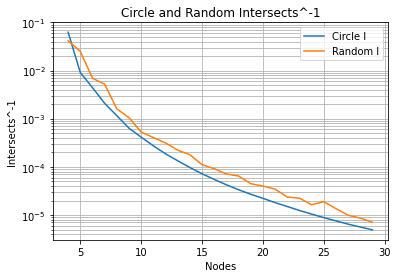

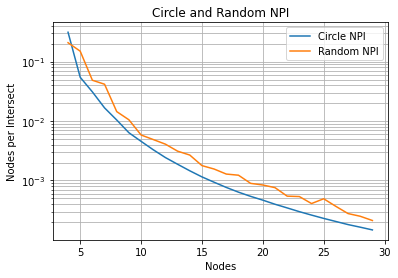

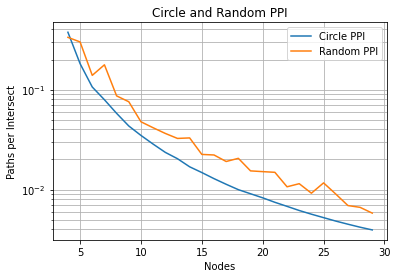

In [338]:
import math
import random
PI = math.pi

#Circle radius
R = 2

#Starting number of towers
START = 4

#Ending number of towers
END = 30

circle_i = np.array([])
circle_npi = np.array([])
circle_ppi = np.array([])

random_i = np.array([])
random_npi = np.array([])
random_ppi = np.array([])
ncount = np.array([])
for n in range(START, END):
    circle_x = [math.cos(2*PI/n*i)*R for i in range(0,n+1)]
    circle_y = [math.sin(2*PI/n*i)*R for i in range(0,n+1)]
    random_x = [random.randint(0, 400)/100 for i in range(0,n+1)]
    random_y = [random.randint(0, 400)/100 for i in range(0,n+1)]

    nodes, paths, x_intersects, y_intersects = contourForest(circle_x, circle_y)
    npi = len(nodes)/len(x_intersects)
    ppi = len(paths)/len(x_intersects)
    circle_i = np.append(circle_i, len(x_intersects)**-1)
    circle_npi = np.append(circle_npi, npi)
    circle_ppi = np.append(circle_ppi, ppi)

    nodes, paths, x_intersects, y_intersects = contourForest(random_x, random_y)
    npi = len(nodes)/len(x_intersects)
    ppi = len(paths)/len(x_intersects)
    random_i = np.append(random_i, len(x_intersects)**-1)
    random_npi = np.append(random_npi, npi)
    random_ppi = np.append(random_ppi, ppi)

    ncount = np.append(ncount, n)

fig = plt.figure()
plt.grid(True, which="both", axis='y')
plt.grid(True, which="both", axis='x')
plt.title("Circle and Random Intersects^-1")
plt.ylabel("Intersects^-1")
plt.xlabel("Nodes")
plt.plot(ncount, circle_i, label="Circle I")
plt.plot(ncount, random_i, label="Random I")
plt.yscale("log")
plt.legend()
plt.show()

fig = plt.figure()
plt.grid(True, which="both", axis='y')
plt.grid(True, which="both", axis='x')
plt.title("Circle and Random NPI")
plt.ylabel("Nodes per Intersect")
plt.xlabel("Nodes")
plt.plot(ncount, circle_npi, label="Circle NPI")
plt.plot(ncount, random_npi, label="Random NPI")
plt.yscale("log")
plt.legend()
plt.show()

fig = plt.figure()
plt.grid(True, which="both", axis='y')
plt.grid(True, which="both", axis='x')
plt.title("Circle and Random PPI")
plt.ylabel("Paths per Intersect")
plt.xlabel("Nodes")
plt.plot(ncount, circle_ppi, label="Circle PPI")
plt.plot(ncount, random_ppi, label="Random PPI")
plt.yscale("log")
plt.legend()
plt.show()    

## Findings
